# Содержание:

    1) Метод N-Grams (n=2) с классификаторами:
            1) Ridge Classifier
            2) Perceptron
            3) Passive Agressive
            4) BeurnolliNB
            5) MultinomialNB
            6) KNeighbors
            7) RandomForest
            8) NearestCentroid
            9) SGDClassifier
            10) LinearSVC
            
    2) Метод N-Grams (n=3) с классификаторами:
            1) Ridge Classifier
            2) Perceptron
            3) Passive Agressive
            4) BeurnolliNB
            5) MultinomialNB
            6) KNeighbors
            7) RandomForest
            8) NearestCentroid
            9) SGDClassifier
            10) LinearSVC



In [8]:
%matplotlib inline
import os
from lxml import etree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from collections import defau


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


## Подготовка данных

In [2]:
f = open('./out.csv', 'r')
cl = {'статья':0,'интервью':1,'комментарий':2}
file_hash = {}
for line in f:
    attrs = line.split(';')
    path = attrs[0]
    class_name = attrs[8]
    if ' ' in class_name:
        class_name = class_name.split()[0]
    if '|' in class_name:
        class_name = class_name.split('|')[0]
    filename = os.path.basename(path)
    if class_name in cl:
        file_hash[filename] = cl[class_name]

In [3]:
def read_txt(path):
    for root, dirs, files in os.walk(path):
        for filename in files:
            open_name = os.path.join(root, filename)
            if filename in file_hash:
                class_text = file_hash[filename]
                tree = etree.parse(open_name)
                yield tree, class_text

In [4]:
sent = []
for tree, class_text in read_txt('/Users/Valeriya/Desktop/CoursePaper/corpus'):
    all_p = tree.xpath('//p')
    joined = '\n'.join([p.text for p in all_p if p.text is not None])
    sent.append((joined, class_text))

In [5]:
sent = sent[:800]

In [6]:
only_texts = [text[0] for text in sent]
classes = [text[1] for text in sent]

In [9]:
d = defaultdict(int)
for word in classes:
    d[word] += 1

### 1) n=2

In [11]:
bigrams = set()
num = 1
for text in sent:
    text_clear = [word.lower().strip('.,!-?»«') for word in text[0].split()]
    text_2grams = list(ngrams(list(text_clear), 2))
    for i in text_2grams:
        bigrams.add(i)
        
bigrams = list(bigrams)

In [12]:
str_bigrams = [' '.join(bi) for bi in bigrams]

In [13]:
index = range(len(sent))

In [14]:
bigrams_per_sent = []
for i, text in enumerate(sent):
    text_clear = [word.lower().strip('.,!-?»«') for word in text[0].split()]  # биграммы из текста
    text_2grams = list(ngrams(list(text_clear), 2)) # биграммы из текста
    str_2grams = set([' '.join(bi) for bi in text_2grams])
    bigrams_per_sent.append(str_2grams)

In [15]:
all_vectors = []
for i, text in enumerate(sent):
    vector = []
    for bi in str_bigrams:
        if bi in bigrams_per_sent[i]:
            vector.append(1)
        else:
            vector.append(0)
    all_vectors.append(vector)

print(len(all_vectors))

800


In [17]:
X_train, X_test, y_train, y_test = train_test_split(all_vectors, classes, test_size=0.3)

In [20]:
X_train_df = pd.DataFrame(X_train)

In [21]:
X_test_df = pd.DataFrame(X_test)

In [26]:
categories = ['статья','интервью','комментарий']

print("Loading dataset for categories:")
print(categories if categories else "all")


print('data loaded')


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()


duration = time() - t0


print("Extracting features from the test data using the same vectorizer")
t0 = time()


duration = time() - t0

print("Extracting best features by a chi-squared test")
t0 = time()
ch2 = SelectKBest(chi2)
X_train__tf_ch = ch2.fit_transform(X_train_df, y_train)
X_test__tf_ch = ch2.transform(X_test_df)
print("done in %fs" % (time() - t0))

Loading dataset for categories:
['статья', 'интервью', 'комментарий']
data loaded
Extracting features from the training data using a sparse vectorizer
Extracting features from the test data using the same vectorizer
Extracting best features by a chi-squared test
done in 10.436984s


In [28]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_df, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_df)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 22.283s
test time:  3.204s
accuracy:   0.650

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 151.203s
test time:  1.092s
accuracy:   0.675

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time

/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 54.953s
test time:  1.355s
accuracy:   0.700

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 237.422s
test time:  1.742s
accuracy:   0.696

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 111.456s
test time:  1.582s
accuracy:   0.679

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 414.114s
test time:  3.181s
accuracy:   0.679

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 490.585s
test time:  2.394s
accuracy:   0.662

NearestCentroid (

### Визуализация (n=2)

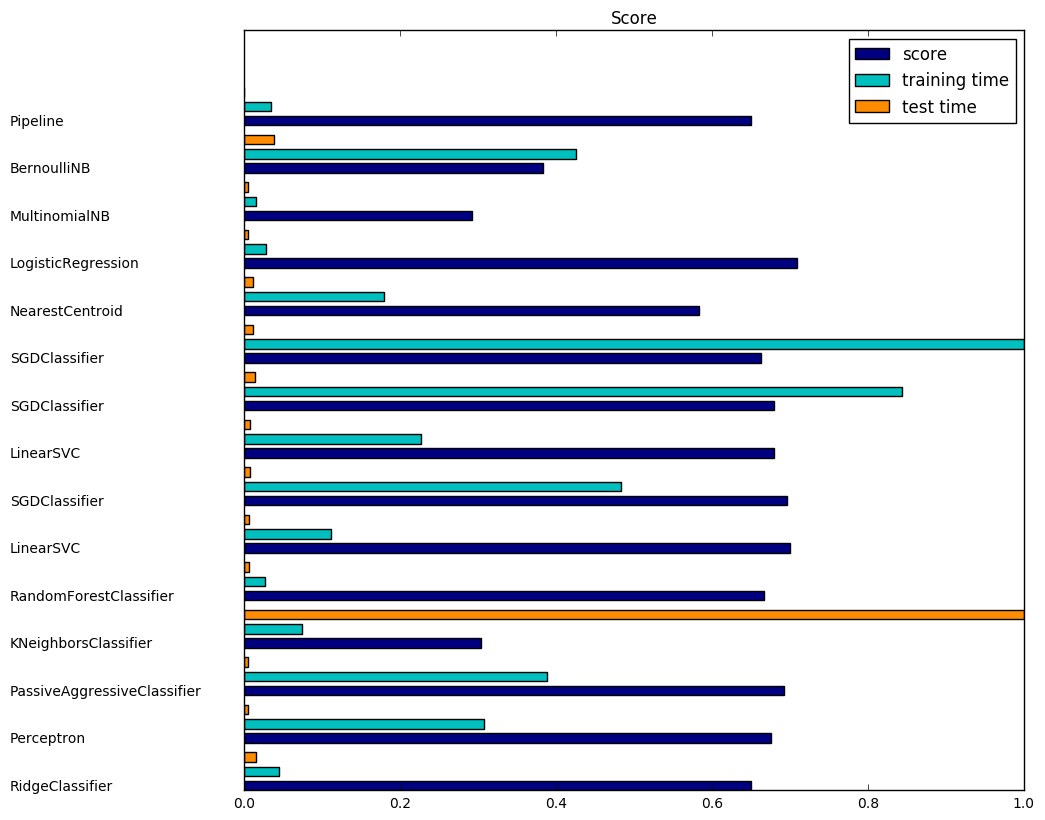

In [29]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.show()

## n=3

In [30]:
trigrams = set()
num = 1
for text in sent:
    text_clear = [word.lower().strip('.,!-?»«') for word in text[0].split()]
    text_3grams = list(ngrams(list(text_clear), 3))
    for i in text_3grams:
        trigrams.add(i)
        
trigrams = list(trigrams)

In [31]:
str_trigrams = [' '.join(tri) for tri in trigrams]
index = range(len(sent))

In [32]:
trigrams_per_sent = []
for i, text in enumerate(sent):
    text_clear = [word.lower().strip('.,!-?»«') for word in text[0].split()]  # биграммы из текста
    text_3grams = list(ngrams(list(text_clear), 3)) # биграммы из текста
    str_3grams = set([' '.join(tri) for tri in text_3grams])
    trigrams_per_sent.append(str_3grams)

In [33]:
all_vectors = []
for i, text in enumerate(sent):
    vector = []
    for tri in str_trigrams:
        if tri in trigrams_per_sent[i]:
            vector.append(1)
        else:
            vector.append(0)
    all_vectors.append(vector)

print(len(all_vectors))

800


In [34]:
X_train, X_test, y_train, y_test = train_test_split(all_vectors, classes, test_size=0.3)

In [35]:
X_train_df_tri = pd.DataFrame(X_train)

In [36]:
X_test_df_tri = pd.DataFrame(X_test)

In [56]:
categories = ['статья','интервью','комментарий']

print("Loading dataset for categories:")
print(categories if categories else "all")


print('data loaded')


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()


duration = time() - t0


print("Extracting features from the test data using the same vectorizer")
t0 = time()


duration = time() - t0

print("Extracting best features by a chi-squared test")
t0 = time()
ch2 = SelectKBest(chi2, k=100000)
X_train__tri_ch = ch2.fit_transform(X_train_df_tri, y_train)
X_test__tri_ch = ch2.transform(X_test_df_tri)
print("done in %fs" % (time() - t0))

Loading dataset for categories:
['статья', 'интервью', 'комментарий']
data loaded
Extracting features from the training data using a sparse vectorizer
Extracting features from the test data using the same vectorizer
Extracting best features by a chi-squared test
done in 16.185657s


In [57]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train__tri_ch, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test__tri_ch)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 6.245s
test time:  0.275s
accuracy:   0.483

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 11.809s
test time:  0.178s
accuracy:   0.583

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 

/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 3.837s
test time:  0.161s
accuracy:   0.483

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 11.251s
test time:  0.158s
accuracy:   0.613

L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', max_iter=1000, multi_class='ovr',
     penalty='l1', random_state=None, tol=0.001, verbose=0)


/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 1.575s
test time:  0.169s
accuracy:   0.646

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 69.006s
test time:  0.222s
accuracy:   0.575

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 73.438s
test time:  0.172s
accuracy:   0.592

NearestCentroid (aka 

### Визуализация

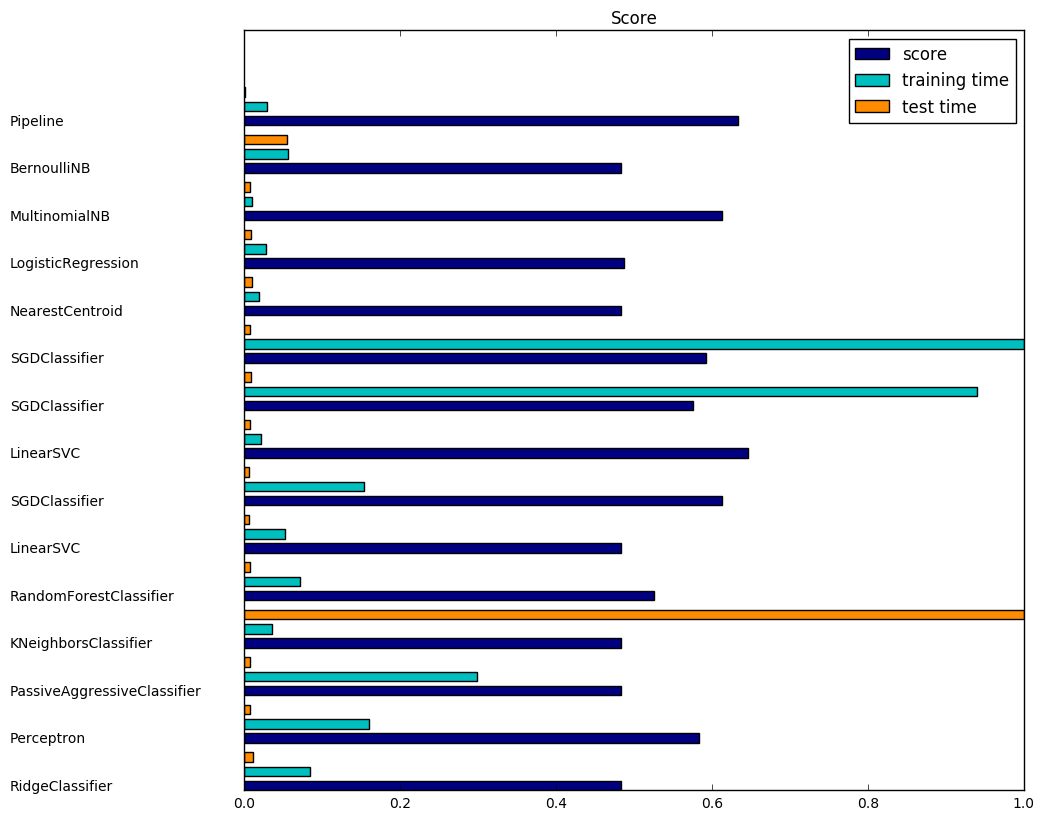

In [58]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)
plt.show()